In [1]:
import torch 
import torch.nn as nn #para implementar capas 
import torch.nn.functional as F #capas de parametros

In [2]:
#implementacion de nuestra red neuronal 
class Net(nn.Module):#una red es una clase que se hereda de un modulo
  def __init__(self, num_channels): #aqui se ponen las capas que tengan paramatros en este caso la cantidad de canales por el cual expandiara la imagen 
    super(Net,self).__init__()  #inicializamos la clase padre

    self.num_channels = num_channels

    # capas de la red en este caso 5 capas
    # 3 convulucionales

    self.conv1 = nn.Conv2d(3,self.num_channels,3,stride = 1,padding=1) #cada capa recibe los siguientes parametros (canales de entrada, canales de salida ,kernel = 3,stride = 1 ,padding = 1) los ultimos tre parametros se usan para no modificar el tamaño de la imagen   
    self.conv2 = nn.Conv2d(self.num_channels,self.num_channels*2,3,stride = 1,padding=1) # expandimos la red
    self.conv3 = nn.Conv2d(self.num_channels*2,self.num_channels*4,3,stride = 1,padding=1) #segumos expandiendo la red

    # y 2 capas lineales 
    self.fc1 = nn.Linear(self.num_channels*4*8*8,self.num_channels*4)
    self.fc2 = nn.Linear(self.num_channels*4,6)

  def forward (self , x ):
      #usamos maxpool(para dividir el tamaño de la imagen )
      ##empieza  por una imagen de 3 canales de 64 px x 64 px 3x64x64
      x = self.conv1(x) #num_channels  x 64 x 64
      x = F.relu(F.max_pool2d(x,2)) #num_channels x 32 x 32
      x = self.conv2(x) #num_channels * 2 x 32 x 32 
      x = F.relu(F.max_pool2d(x,2))# num_channels *2 x 16 x 16
      x = self.conv3(x)# num_channels *4 x 16 x 16
      x = F.relu(F.max_pool2d(x,2))#num_channels *4 x 8 x 8
      #flatten
      #Implementamos las capas lineales 
      #-1 idica que haremos el flatten
      #sitaxis x.view(-1,tamanio del tensor)
      x = x.view(-1,self.num_channels*4*8*8) 

      #fc 
      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc2(x)

      #log_sofmax
      #esta funcion nos permite tener probalidades al final y hacer una clasificacion multiclase 
      #
      x = F.log_softmax(x,dim=1)

      return x

In [3]:
#importamos nuestro Drive dandole acceso a nuestro goggle drive 
from google.colab import drive 
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
#nos aseguramos de que es lo que tenemos en nuestro DataSet
!ls '/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS'

test_signs  train_signs  val_signs


In [5]:
#importamos las librerias de ploting 
import sys 
sys.path.append('/gdrive/My Drive/dl-pytorch/')

In [6]:
#importamos plothelpers del propio drive
from plot_helpers import imshow

In [7]:
##empezamos con el montaje del dataSet
#en este caso se hereda de otra clase de pytorch
# dentro de la clase tendremos tres metodos (init(que setteara todos los atrubutos),lenght(catidad de imagenes del dataset),getItem(esta ligado a una lista para acceder a un elemento de la lista ))
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader

class SINGSDataset(Dataset):
  #los paremtros que tendra el primer metodo (self,direccionDataset,splitde datos, Pipelines de procesamiento)
  def __init__(self, base_dir,split="train",transform=None):
    #definimos el camino al directorio de las imagenes
    path = os.path.join(base_dir,"{}_signs".format(split))
    #vemos todos los archivos dentro de la ruta
    files = os.listdir(path)

    self.filenames = [os.path.join(path,f) for f in  files if f.endswith (".jpg")]

    self.targets = [int(f[0]) for f in files]
    self.transform = transform

  def __len__(self):
    return len (self.filenames)

  def __getitem__(self,idx):
    image=Image.open(self.filenames[idx])
    if self.transform:
      image = self.transform(image)
    return image, self.targets[idx]

In [8]:
#cargamos el dataset
signs = SINGSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS', split="train")

In [9]:
len(signs)

864

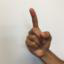

In [10]:
signs[0][0]

In [11]:
#importamos una libreria de funciones de preprocesamiento estas nos sirve para tener todas la imagenes como tensores
import torchvision.transforms as transforms 

In [12]:
#creamos el dataSet agregando la fase de preprocesamiento para convertirlos en tensores
trainset = SINGSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS', split="train",transform=transforms.ToTensor() )

In [13]:
#montamos el dataLoader (este generara los baches en el set de datos)
#en otras palabras entregara por baches las imagenes a la red neuronal

dataloader= DataLoader(trainset,batch_size=32)

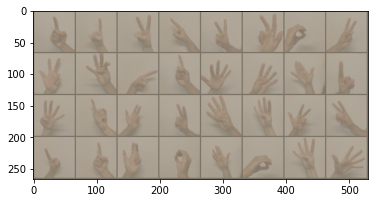

tensor([1, 1, 2, 1, 2, 3, 0, 2, 3, 4, 1, 1, 5, 4, 5, 1, 4, 1, 3, 2, 4, 4, 3, 2,
        1, 1, 3, 0, 5, 0, 4, 5])


In [14]:
#usando la libreria de las utilidades 
#nos entrega las imagenes por pedazos

from torchvision.utils import make_grid
for inputs , targets in dataloader:
  out = make_grid(inputs)
  imshow(out)
  print(targets)
  break

In [15]:
#importamos la libreria optim (metodos de optimizacion)
import torch.optim as optim

In [16]:
#antes de entrenar la red tenemos que instanciar la red , la gpu , la funcion de perdida y el optimizador (stocastic gradient desend (SDG))
device = torch.device('cuda')

In [17]:
net = Net(32).to(device)

loss_fn = nn.NLLLoss()
optimizer= optim.SGD(net.parameters(),lr=1e-3,momentum=0.9)

In [18]:
##Funcion auxiliar para empaquetar el codigo 
#esta clase calculara promedios en el tiempo 
class RunningMetric():
  def __init__(self):
    self.S=0
    self.N=0
  def update (self,val,size):
    self.S+=val
    self.N+=size
  def __call__(self):
    return self.S/float(self.N)

In [19]:
#primero definimos la cantidad e epochs(en palabras mas sencillas es cuantas veces pasara por el data set entero)
num_epochs = 100

In [21]:
for epoch in range(num_epochs):
  print('Epoch {}/{} '.format(epoch+1,num_epochs))
  print('-'*10)

  running_loss = RunningMetric()
  running_acc = RunningMetric

  for inputs ,targets in dataloader:
    inputs,targets = inputs.to(device),targets.to(device)
    optimizer.zero_grad()

    outputs = net(inputs)
    _, preds = torch.max(outputs,1)
    loss = loss_fn = (outputs,targets)
    
    loss.backward() ## gradientes claculados automaticamente
    optimizer.step()## actualiza los parametros

    batch_size = inputs.size()[0]
    running_loss.update(loss.item()*batch_size,batch_size )
    running_acc.update(torch.sum(preds == targets).float(), batch_size)
  print('Loss: {:.4f} Acc: {:.4f}'.format(running_loss(),running_acc()))


Epoch 1/100 
----------


AttributeError: ignored